## Data Loading

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

query = """
SELECT * FROM stations;
"""

stations = pd.read_sql(sqla.text(query), connection)

data_province = [
    (0,"Bruxelles", 4.367414882050033, 50.83642580516115),
    (1,"Antwerpen", 4.721043779498864, 51.231900712244745),
    (2,"Limburg", 5.4357209224443475, 50.98831159244354),
    (3,"Oost-Vlaanderen", 3.8188605810442007, 51.03629347952689),
    (4,"Vlaams Brabant", 4.59072072950776, 50.87303943005528),
    (5,"West-Vlaanderen", 3.0620446668608117, 51.01019740435232),
    (6,"Brabant Wallon", 4.589736973914637, 50.66605965845173),
    (7,"Hainaut", 3.9681364929631004, 50.46387637972707),
    (8,"Liège", 5.7372263688290746, 50.518876085615986),
    (9,"Luxembourg", 5.516735682549194, 49.95849015160492),
    (10,"Namur", 4.862346452029854, 50.252686235186815),
]

province = pd.DataFrame(data_province, columns=["province_id", "province_name", "province_long", "province_lat"])

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def find_nearest_province(station_row):
    distances = haversine(
        station_row['longitude'], station_row['latitude'],
        province['province_long'].values, province['province_lat'].values
    )
    nearest_idx = distances.argmin()
    return province.iloc[nearest_idx]

# Apply the function
nearest_provinces = stations.apply(find_nearest_province, axis=1)

# Concatenate station info with nearest province
stations_with_province = pd.concat([stations.reset_index(drop=True), nearest_provinces.reset_index(drop=True)], axis=1)

road = [159,151,149,150,156,157,154,245,773,132,310,365,422,300,628,614,591,
 540,118,178,235,281,480,108,642,625,623,557,558,384,199,559,645,123,195,73,
 261,560,187,438,172,342,341,80,503,629,267,313,608,339,452,564,493,
 317,704,757,70]

filtered_stations = stations_with_province[stations_with_province['id'].isin(road)]
filtered_stations = filtered_stations.drop(columns=['province_long', 'province_lat','region', 'latitude', 'longitude','geom', 'name', 'province_name'])
filtered_stations['id'] = pd.Categorical(filtered_stations['id'], categories=road, ordered=True)
filtered_stations = filtered_stations.sort_values('id').reset_index(drop=True)

query = """
SELECT 
    td.id,
    td.departure_date,
    td.train_number,
    td.relation,
    td.train_service,
    td.ptcar_number,
    td.line_number_departure,
    td.real_time_arrival,
    td.real_time_departure,
    td.planned_time_arrival,
    td.planned_time_departure,
    td.delay_arrival,
    td.delay_departure,
    ptcar.id AS ptcar_id,     
    ptcar.name AS name_travel,    
    td.line_number_arrival,
    dep.name AS departure_station_name,
    arr.name AS arrival_station_name,
    ptcar.longitude AS ptcar_longitude,  
    ptcar.latitude AS ptcar_latitude  
FROM train_data td
JOIN STATIONS ptcar ON td.ptcar_name = ptcar.id
JOIN STATIONS dep ON td.station_departure = dep.id
JOIN STATIONS arr ON td.station_arrival = arr.id
WHERE td.station_arrival = '487'  
  AND td.station_departure = '159'  
ORDER BY td.id;
"""

line = pd.read_sql(sqla.text(query), connection)
line =line.drop(columns=['train_service', 'relation'])
print("Road:", len(road))

tempo = []
clean = []
road_index = 0

for i, row in line.iterrows():
    ptcar_id = row['ptcar_id']
    if ptcar_id == road[road_index]:
        tempo.append(row)
        road_index += 1
        if len(tempo) == len(road):
            clean.extend(tempo)
            tempo = []
            road_index = 0
    else:
        tempo = []
        road_index = 0

clean_df = pd.DataFrame(clean)

query = """
    SELECT * FROM TYPE_DAY;
"""


type_day = pd.read_sql(sqla.text(query), connection)
clean_df= clean_df.drop(columns=['departure_station_name','arrival_station_name','id', 'name_travel', 'ptcar_number','ptcar_id'])
merged_df = pd.merge(clean_df, type_day, left_on='departure_date', right_on='date', how='left')
merged_df.loc[merged_df.index[::57], "delay_arrival"] = 0

merged_df.loc[merged_df.index[::57], "real_time_arrival"] = merged_df.loc[merged_df.index[::57], "real_time_departure"]
merged_df.loc[merged_df.index[::57], "planned_time_arrival"] = merged_df.loc[merged_df.index[::57], "planned_time_departure"]
merged_df.loc[merged_df.index[::57], "line_number_arrival"] = merged_df.loc[merged_df.index[::57], "line_number_departure"]


merged_df.loc[merged_df.index[56::57], "line_number_departure"] = 162
merged_df.loc[merged_df.index[56::57], "line_number_arrival"] = 162

index = merged_df.index[56::57]
mask = merged_df.loc[index, "real_time_departure"] == None
merged_df.loc[index, "real_time_departure"] = merged_df.loc[index, "real_time_arrival"]

mask = merged_df.loc[index, "planned_time_departure"] == None
merged_df.loc[index, "planned_time_departure"] = merged_df.loc[index, "planned_time_arrival"]

mask = merged_df.loc[index, "delay_departure"] == None
merged_df.loc[index, "delay_departure"] = merged_df.loc[index, "delay_arrival"]

station_ids = filtered_stations['province_id'].values
total_rows = 1558950
repeated_ids = np.tile(station_ids, total_rows // len(station_ids) + 1)[:total_rows]

repeated_ids_df = pd.DataFrame({'repeated_station_id': repeated_ids})
merged_df = pd.concat([merged_df, repeated_ids_df], axis=1)
query = """
SELECT 
    w.date,
    EXTRACT(HOUR FROM w.hour) AS hour_of_day,
    w.temperature AS temperature,
    w.dewpoint AS dewpoint,
    w.relative_humidity AS relative_humidity,
    w.precipitation AS precipitation,
    w.snowfall AS snowfall,
    w.wind_direction AS wind_direction,
    w.wind_speed AS wind_speed,
    w.pressure AS pressure,
    w.province AS province_id
FROM WEATHER w
GROUP BY 
    w.date,
    EXTRACT(HOUR FROM w.hour),
    w.temperature,
    w.dewpoint,
    w.relative_humidity,
    w.precipitation,
    w.snowfall,
    w.wind_direction,
    w.wind_speed,
    w.pressure,
    w.province
ORDER BY w.date, hour_of_day;

"""

weather = pd.read_sql(sqla.text(query), connection)

merged_df['time'] = pd.to_datetime(merged_df['planned_time_arrival'], format='%H:%M:%S')
merged_df['hour'] = merged_df['time'].dt.hour

final_df = pd.merge(merged_df, weather, left_on=['departure_date', 'hour','repeated_station_id'], right_on=['date', 'hour_of_day','province_id'], how='left')
final_df = final_df.drop(columns=['date_x', 'date_y', 'hour_of_day','time','hour','repeated_station_id'])
print("Middle of processing")
def parse_time_to_seconds(val):
    if pd.isna(val):
        return 0
    try:
        if isinstance(val, (int, float)):
            return int(val)
        if str(val).isdigit():
            return int(val)
        t = pd.to_datetime(val, format='%H:%M:%S', errors='coerce')
        if pd.isna(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0


final_df['departure_date'] = pd.to_datetime(final_df['departure_date'], format='%Y-%m-%d')

final_df['departure_year'] = final_df['departure_date'].dt.year
final_df['departure_month'] = final_df['departure_date'].dt.month
final_df['departure_day'] = final_df['departure_date'].dt.day
final_df['departure_weekday'] = final_df['departure_date'].dt.weekday

final_df['real_time_arrival'] = final_df['real_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_arrival'] = final_df['planned_time_arrival'].apply(parse_time_to_seconds)
final_df['planned_time_departure'] = final_df['planned_time_departure'].apply(parse_time_to_seconds)
final_df['real_time_departure'] = final_df['real_time_departure'].apply(parse_time_to_seconds)

final_df = final_df.drop(columns=['departure_date', 'line_number_departure', 'line_number_arrival' ,'train_number'])
final_df['delay_arrival'] = final_df['delay_arrival'].apply(parse_time_to_seconds)

trajet_valid = []

for i in range(0, len(final_df), 57):
    trajet = final_df.iloc[i:i+57]
    if trajet.shape[0] < 57:
        print("Not enough data for this trajet, skipping")
        continue

    if trajet.isnull().values.any():
        continue

    if trajet['delay_arrival'].abs().max() > 36000:
        print("Delay arrival exceeds 10000 seconds, skipping")
        continue

    trajet_valid.append(trajet)

trajet_valid_df = pd.concat(trajet_valid, ignore_index=True)
trajet_valid_df["stop_index"] = trajet_valid_df.index % 57

Connected to PostgreSQL successfully!
Road: 57
In Loading...
Skipping trajet starting at index 294804: contains NaN
Skipping trajet starting at index 1427622: contains NaN
Skipping trajet starting at index 1427679: contains NaN


## Model 

In [ ]:
from sklearn.linear_model import LinearRegression

def create_dataset(df, input_stops=15, target_stop=35, stops_per_trip=57):

    X_list = []
    y_list = []
    
    features_columns = [
        'planned_time_arrival', 'planned_time_departure',
        'delay_arrival', 'delay_departure',
        'ptcar_latitude', 'ptcar_longitude',
        'holiday', 'weekend', 'day_after_rest',
        'temperature', 'dewpoint', 'relative_humidity',
        'precipitation', 'snowfall', 'wind_direction',
        'wind_speed', 'pressure','departure_month','departure_day','departure_weekday','departure_year'         
    ]
    
    for i in range(0, len(df), stops_per_trip):
        trajet = df.iloc[i:i+stops_per_trip]
        
        if trajet.shape[0] < stops_per_trip:
            continue
        features = trajet.iloc[:input_stops][features_columns].values.flatten()
        target = trajet.iloc[target_stop]['delay_arrival']
        
        X_list.append(features)
        y_list.append(target)
        
    return np.array(X_list), np.array(y_list)

def create_dataset_stop(df, start_index=14, target_stop=35, stops_per_trip=57):
    X_list = []
    y_list = []

    features_columns = [
        'planned_time_arrival', 'planned_time_departure',
        'delay_arrival', 'delay_departure',
        'ptcar_latitude', 'ptcar_longitude',
        'holiday', 'weekend', 'day_after_rest',
        'temperature', 'dewpoint', 'relative_humidity',
        'precipitation', 'snowfall', 'wind_direction',
        'wind_speed', 'pressure',
        'departure_month','departure_day','departure_weekday','departure_year'
    ]
    
    for i in range(0, len(df), stops_per_trip):
        trajet = df.iloc[i:i+stops_per_trip]
        if trajet.shape[0] < stops_per_trip:
            continue
        features = trajet.iloc[start_index][features_columns].values
        target = trajet.iloc[target_stop]['delay_arrival']

        X_list.append(features)
        y_list.append(target)
        
    return np.array(X_list), np.array(y_list)

def create_new_dataset(df, input_stops=15, target_stop=35, stops_per_trip=57):
    X_list = []
    y_list = []

    features_columns = ['delay_arrival', 'delay_departure']
    
    for i in range(0, len(df), stops_per_trip):
        trajet = df.iloc[i:i+stops_per_trip]
        
        if trajet.shape[0] < stops_per_trip:
            continue
        features = trajet.iloc[input_stops][features_columns].values
        target = trajet.iloc[target_stop]['delay_arrival']
        
        X_list.append(features)
        y_list.append(target)
        
    return np.array(X_list), np.array(y_list)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
def testing_target(target, dataset, start, start2):
    r2_scores = []
    for target in target:
        testX, testY = create_dataset(dataset, input_stops=start, target_stop=target, stops_per_trip=57)
        X_train = testX[:int(len(testX) * 0.8)]
        y_train = testY[:int(len(testY) * 0.8)]
        X_test = testX[int(len(testX) * 0.8):]
        y_test = testY[int(len(testY) * 0.8):]
        rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        r2 = r2_score(y_test, y_pred)
    return r2_scores

def testing_target2(target,dataset,start):
    r2_scores = []
    for target in target:
        test2X, test2Y = create_dataset_stop(dataset, start_index=start, target_stop=target, stops_per_trip=57)
        X_train2 = test2X[:int(len(test2X) * 0.8)]
        y_train2 = test2Y[:int(len(test2Y) * 0.8)]
        X_test2 = test2X[int(len(test2X) * 0.8):]
        y_test2 = test2Y[int(len(test2Y) * 0.8):]
        rf2 = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
        rf2.fit(X_train2, y_train2)
        y_pred2 = rf2.predict(X_test2)
        r2 = r2_score(y_test2, y_pred2)
        r2_scores.append(r2)
    return r2_scores

def testing_target3(target,dataset,start):
    r2_scores = []
    for target in target:
        test2X, test2Y = create_new_dataset(dataset, input_stops=start, target_stop=target, stops_per_trip=57)
        X_train2 = test2X[:int(len(test2X) * 0.8)]
        y_train2 = test2Y[:int(len(test2Y) * 0.8)]
        X_test2 = test2X[int(len(test2X) * 0.8):]
        y_test2 = test2Y[int(len(test2Y) * 0.8):]
        rf2 = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
        rf2.fit(X_train2, y_train2)
        y_pred2 = rf2.predict(X_test2)
        r2 = r2_score(y_test2, y_pred2)
        r2_scores.append(r2)
    return r2_scores

def naive_target(target, dataset, start):
    r2_scores = []
    for target in target:
        testX, testY = create_dataset_stop(dataset, start_index=start, target_stop=target, stops_per_trip=57)
        X_train = testX[:int(len(testX) * 0.8)]
        y_train = testY[:int(len(testY) * 0.8)]
        X_test = testX[int(len(testX) * 0.8):]
        y_test = testY[int(len(testY) * 0.8):]
        lg = LinearRegression()
        lg.fit(X_train, y_train)
        y_pred = lg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    return r2_scores

## One station ahead

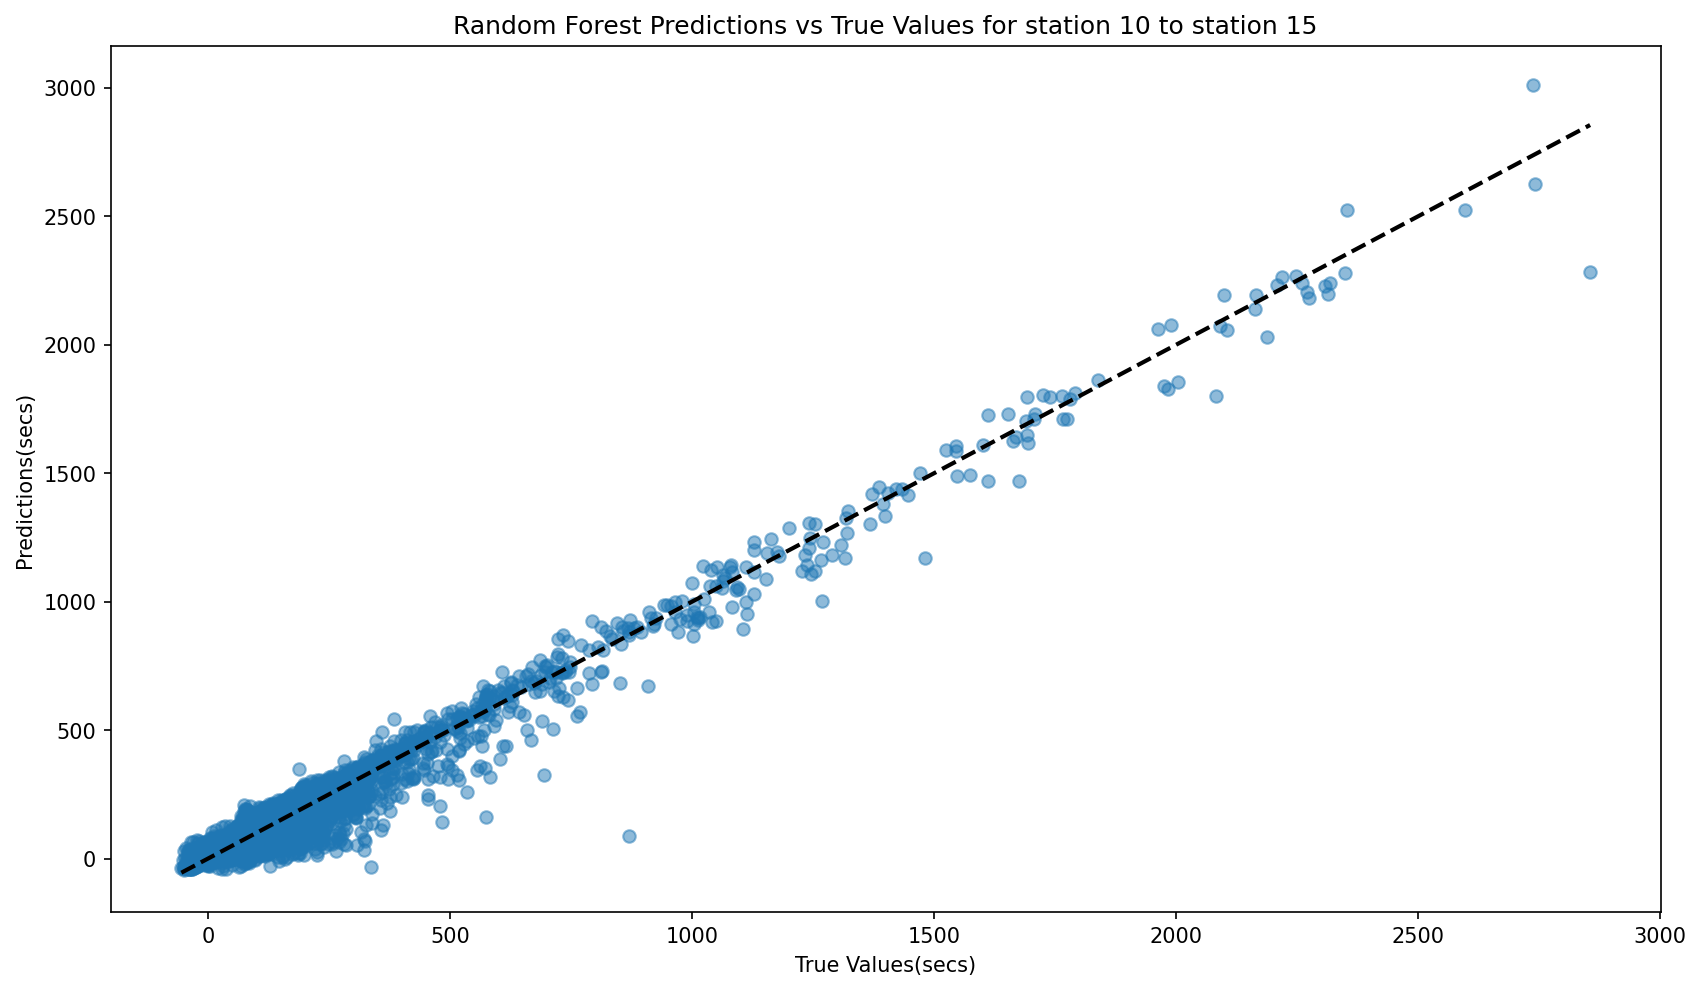

In [3]:
testX, testY = create_dataset_stop(trajet_valid_df, start_index=1, target_stop=2, stops_per_trip=57)

X_train,X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values(secs)')
plt.ylabel('Predictions(secs)')
plt.title('Random Forest Predictions vs True Values for station 1 to station 2')
plt.show()

In [9]:
#Naive Baseline Model #Run just once to see the results
total = []
for i in range(0, 56):
    target = [i+1]
    r2_scores = naive_target(target, trajet_valid_df, i)
    total.append(r2_scores)
print(np.mean(total),np.min(total),np.max(total))


-5361.983117921756 -295249.3579377174 0.997574175056077


In [4]:
total = []
mini = 1
for i in range(0, 56):
    target = [i+1]
    r2_scores = testing_target2(target, trajet_valid_df, i) #More features here
    total.append(r2_scores)
    if r2_scores[0]< mini:
        mini = r2_scores[0]
        print("New minimum:", mini, "for target:", i+1)

print(np.mean(total),np.min(total),np.max(total))

New minimum: 0.9579249316277297 for target: 1
New minimum: 0.9412477970617057 for target: 2
New minimum: 0.9382575610515276 for target: 16
New minimum: 0.9372455858334344 for target: 27
New minimum: 0.9098169835178465 for target: 47
0.9788339600419725 0.9098169835178465 0.9974174457503738


In [5]:
total = []
mini = 1
for i in range(0, 56):
    target = [i+1]
    r2_scores = testing_target3(target, trajet_valid_df, i)#Using testing_target3
    total.append(r2_scores)
    if r2_scores[0]< mini:
        mini = r2_scores[0]
        print("New minimum:", mini, "for target:", i+1)

print(np.mean(total),np.min(total),np.max(total))

New minimum: 0.9409949656789235 for target: 1
New minimum: 0.9359012234729217 for target: 2
New minimum: 0.9289913382557822 for target: 16
New minimum: 0.9221573474785669 for target: 27
New minimum: 0.9025500500241089 for target: 47
0.9765856790877174 0.9025500500241089 0.9965484138105289


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import numpy as np

def testing_target2_with_uncertainty_kfold(targets, dataset, start, n_splits=5):
    r2_scores = []
    mean_variances = []

    for target in targets:
        X, y = create_dataset_stop(dataset, start_index=start, target_stop=target, stops_per_trip=57)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        r2_per_fold = []
        var_per_fold = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
            rf.fit(X_train, y_train)

            all_preds = np.array([tree.predict(X_test) for tree in rf.estimators_]) 
            y_pred = np.mean(all_preds, axis=0)
            y_std = np.std(all_preds, axis=0)

            r2 = r2_score(y_test, y_pred)
            r2_per_fold.append(r2)
            var_per_fold.append(np.mean(y_std ** 2))  

        r2_scores.append(r2_per_fold)
        mean_variances.append(var_per_fold)

    return r2_scores, mean_variances



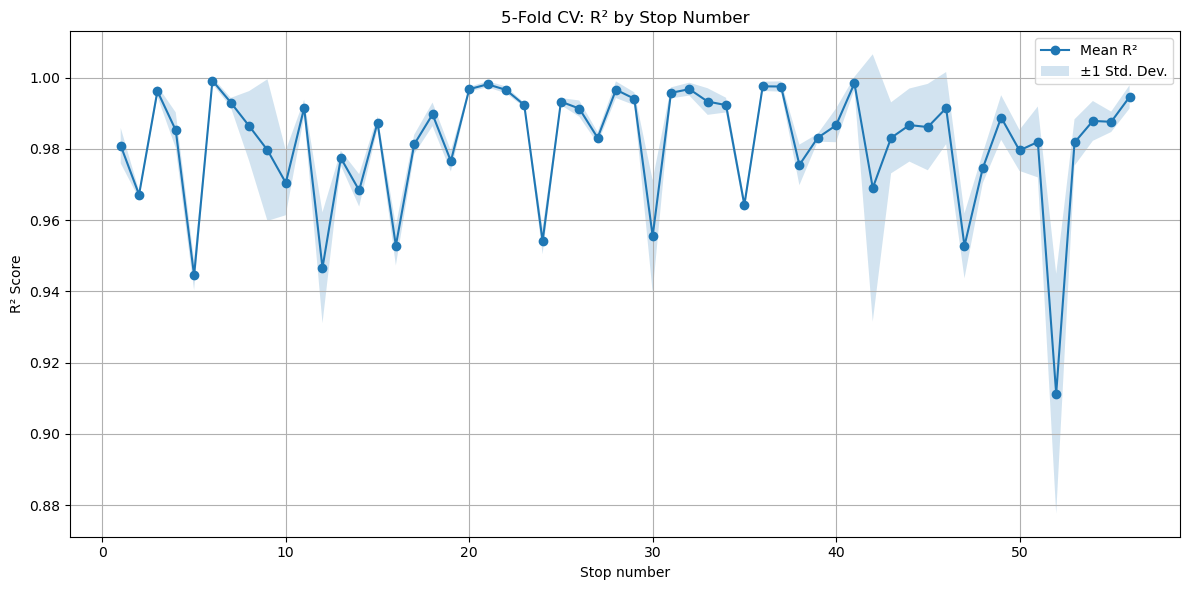

In [33]:
n_splits = 5
all_r2 = []
all_variances = []

for stop in range(56):
    target = [stop + 1]
    r2_scores, variances = testing_target2_with_uncertainty_kfold(target, trajet_valid_df, stop, n_splits=n_splits)
    all_r2.append(r2_scores[0])        
    all_variances.append(variances[0])  

all_r2 = np.array(all_r2)           
all_variances = np.array(all_variances)

mean_r2 = np.mean(all_r2, axis=1)
std_r2 = np.std(all_r2, axis=1)
stops = np.arange(1, 57)

plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops, mean_r2 - std_r2, mean_r2 + std_r2, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² by Stop Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Q Multiple Ahead station

In [ ]:
# Naive run  Q = 5

total = []
for i in range(0, 51):
    target = [i+5]
    r2_scores = naive_target(target, trajet_valid_df, i) 
    total.append(r2_scores)
print(np.mean(total), np.min(total),np.max(total), np.median(total))

-624564.9792482625 -31840918.75773917 0.9684642795449365


In [6]:
# Q = 5

total = []
for i in range(0, 51):
    target = [i+5]
    r2_scores = testing_target2(target, trajet_valid_df, i)
    total.append(r2_scores)
print(np.mean(total), np.min(total),np.max(total))

0.8624891801077423 0.7375077875375022 0.9635167633960776


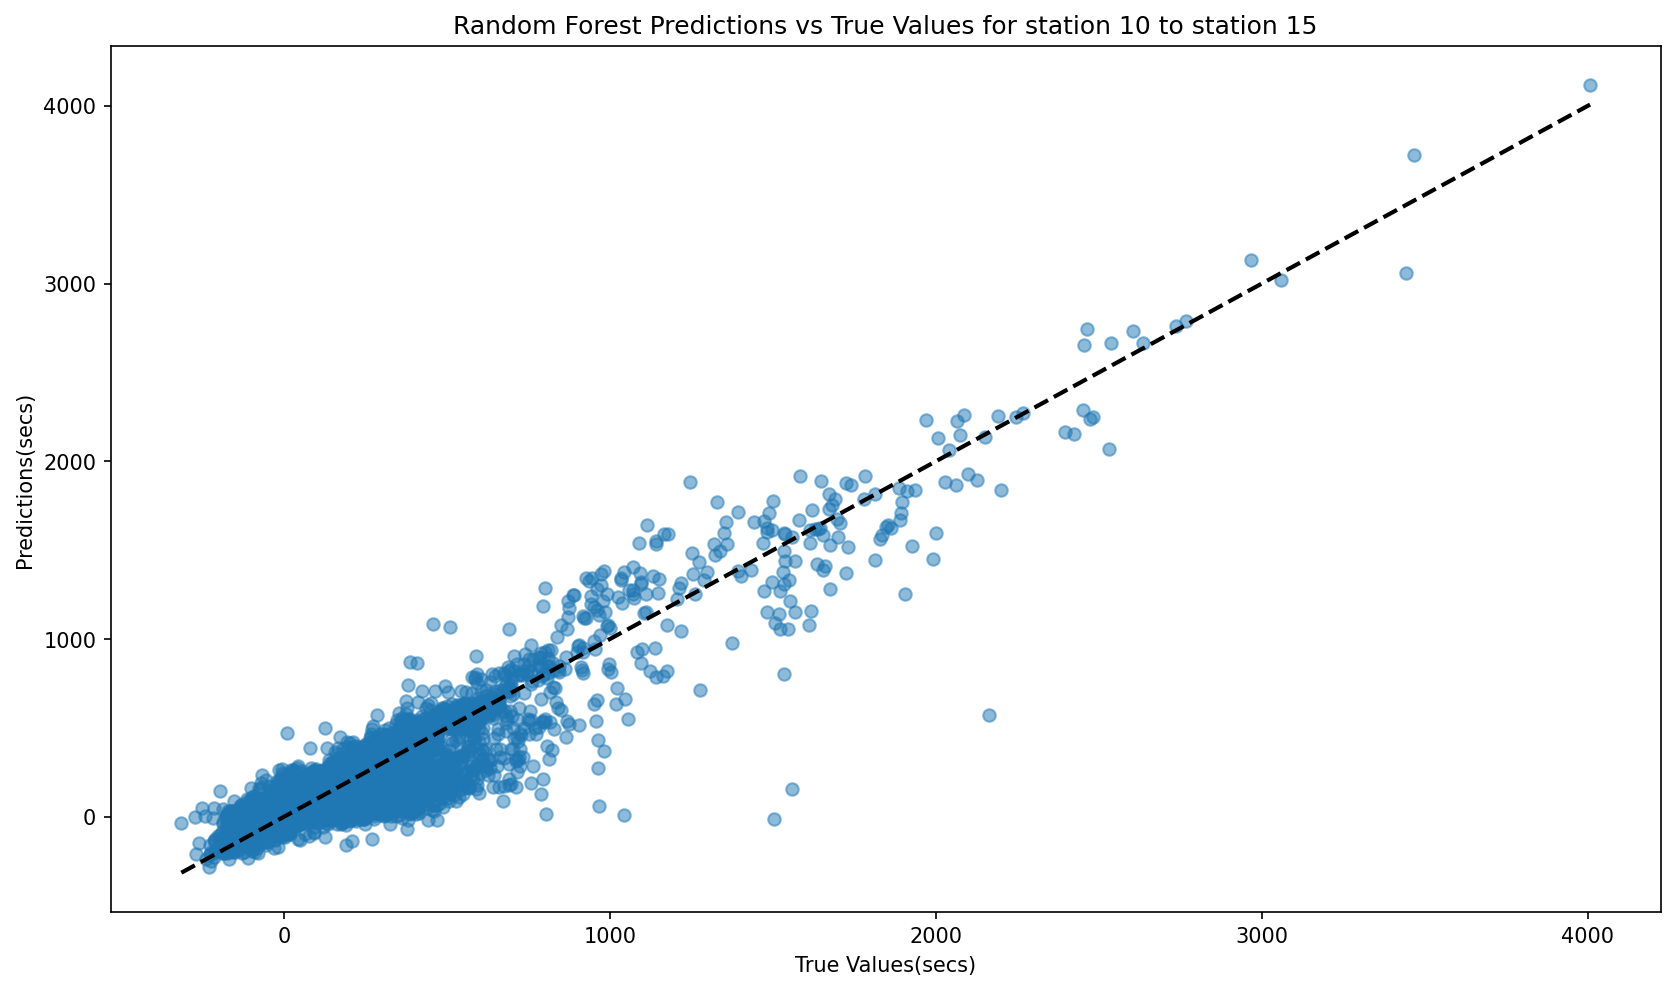

In [7]:
#Q = 5
testX, testY = create_dataset_stop(trajet_valid_df, start_index=10, target_stop=15, stops_per_trip=57)
X_train = testX[:int(len(testX) * 0.8)]
y_train = testY[:int(len(testY) * 0.8)]
X_test = testX[int(len(testX) * 0.8):]
y_test = testY[int(len(testY) * 0.8):]

rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values(secs)')
plt.ylabel('Predictions(secs)')
plt.title('Random Forest Predictions vs True Values for station 10 to station 15')
plt.show()

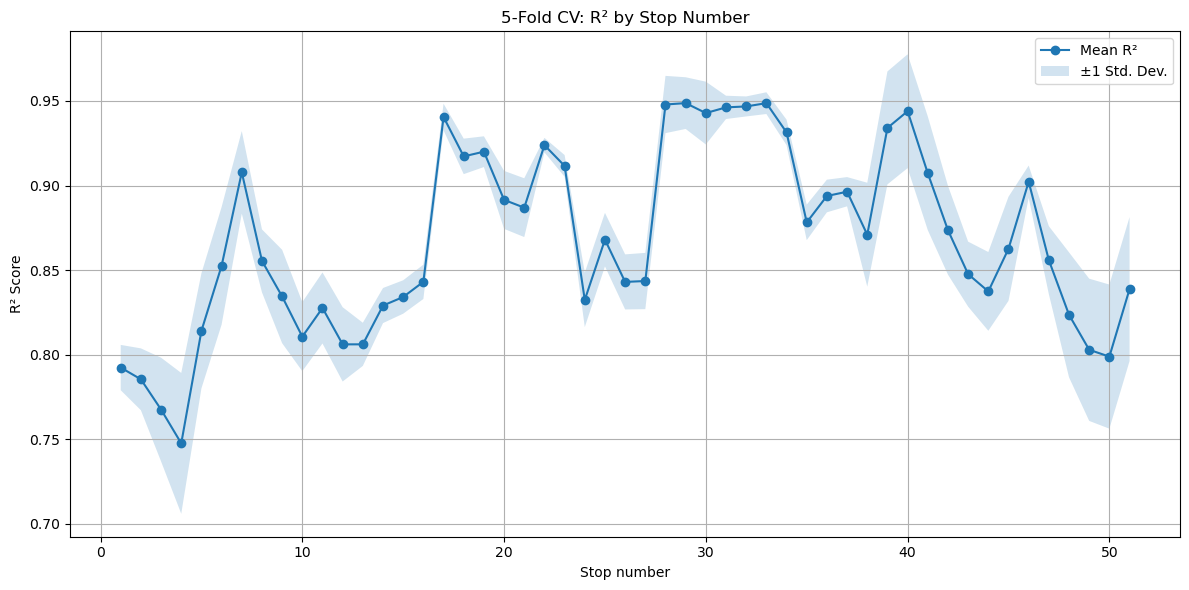

In [35]:
n_splits = 5
all_r2 = []
all_variances = []

for stop in range(51):
    target = [stop + 5]
    r2_scores, variances = testing_target2_with_uncertainty_kfold(target, trajet_valid_df, stop, n_splits=n_splits)
    all_r2.append(r2_scores[0])        
    all_variances.append(variances[0])  

all_r2 = np.array(all_r2)           
all_variances = np.array(all_variances)

mean_r2 = np.mean(all_r2, axis=1)
std_r2 = np.std(all_r2, axis=1)
stops = np.arange(1, 52)

plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops, mean_r2 - std_r2, mean_r2 + std_r2, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² by Stop Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Q = 10

In [24]:
# Naive run  Q = 10

total = []
for i in range(0, 46):
    target = [i+10]
    r2_scores = naive_target(target, trajet_valid_df, i) 
    total.append(r2_scores)
print(np.mean(total), np.min(total),np.max(total), np.median(total))

-666218.595046942 -30543284.931060106 0.9483290693225039 0.7439017867696511


In [25]:
for i in range(0, 46):
    print(total[i])

[0.643614980325407]
[0.5872177340856446]
[0.6793048664233665]
[0.66065190690258]
[0.6872257602406154]
[0.7159452266738437]
[0.7251317227606985]
[0.6862786812581212]
[0.6838473901353066]
[0.6884099064589223]
[0.7134309700902606]
[0.7465208689870211]
[0.7578562431973705]
[0.7698225117262386]
[0.7802803090865521]
[0.7412827045522813]
[0.8691740192326389]
[0.858975405138249]
[0.7900598552546759]
[-30543284.931060106]
[0.7467012362988465]
[0.8090957978634697]
[0.7968185316499784]
[0.8053470675649047]
[0.83838831579176]
[0.8633812399580058]
[0.8569877175227996]
[0.9483290693225039]
[0.9232821211309148]
[0.8470901013033808]
[0.7879377376675132]
[-4486.457761796411]
[0.740058557470054]
[0.7737145085361061]
[0.6539731139560154]
[0.7687721151846454]
[0.7761730134113022]
[-98316.03218628565]
[0.7714905182437585]
[0.7811571388510431]
[0.7347853362249619]
[0.6268095898987512]
[0.604972673501895]
[0.5811932074091894]
[0.5759687793223477]
[0.6513903045174587]


In [23]:
# Q = 10
total_10 = []
mini = 1
for i in range(0, 46):
    target = [i+10]
    r2_scores = testing_target2(target, trajet_valid_df, i) #More features here
    total_10.append(r2_scores)
    if r2_scores[0]< mini:
        mini = r2_scores[0]
        print("New minimum:", mini, "for target:", i+1)

print(np.mean(total_10),np.min(total_10),np.max(total_10),np.median(total_10))

New minimum: 0.6199419555836723 for target: 1
New minimum: 0.5397449608309115 for target: 2
0.7470532529638545 0.5397449608309115 0.9283241116049614 0.7520674169843722


In [8]:
#Q = 10
total_10_2 = []
mini = 1
for i in range(0, 46):
    target = [i+10]
    r2_scores = testing_target3(target, trajet_valid_df, i)#Using testing_target3
    total_10_2.append(r2_scores)
    if r2_scores[0]< mini:
        mini = r2_scores[0]
        print("New minimum:", mini, "for target:", i+1)

print(np.mean(total_10_2),np.min(total_10_2),np.max(total_10_2))

New minimum: 0.5344754689709441 for target: 1
New minimum: 0.3986944446639582 for target: 2
0.7080496069653684 0.3986944446639582 0.9163962997938984


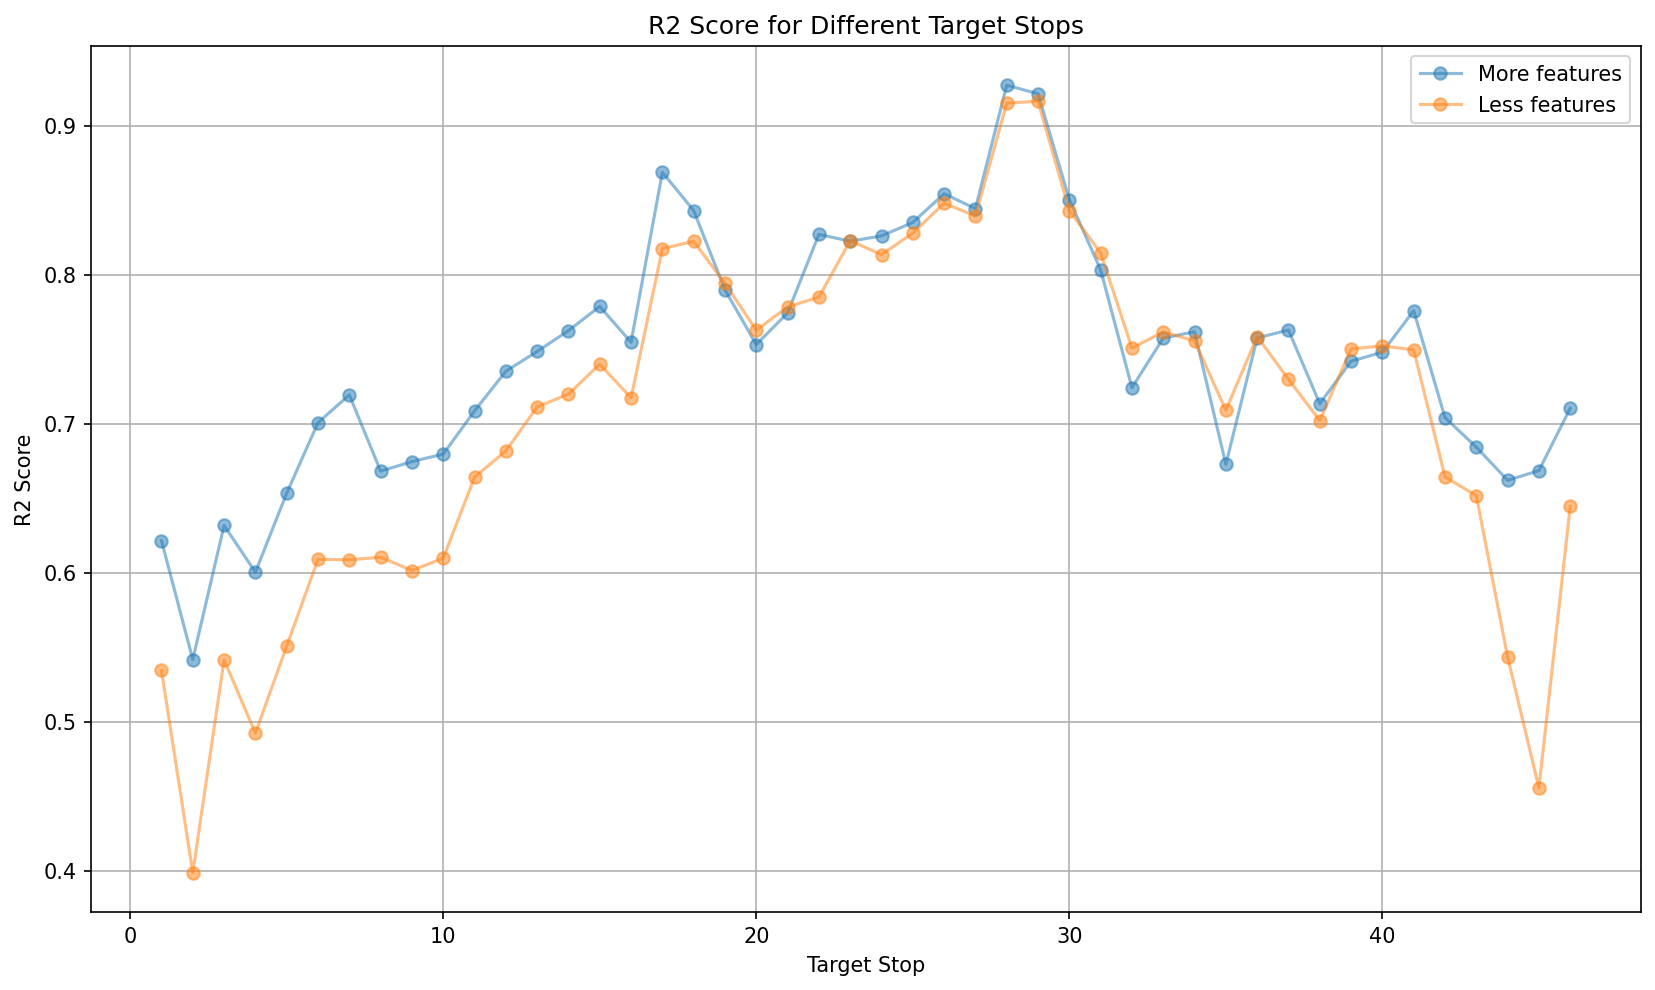

In [13]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.plot(range(1, 47), total_10, label='More features', marker='o',alpha=0.5)
ax.plot(range(1, 47), total_10_2, label='Less features', marker='o',alpha=0.5)
ax.set_xlabel('Target Stop')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Different Target Stops')
ax.legend()
plt.grid()
plt.show()

In [ ]:
# Q = 10 
total = []

for i in range(0, 46):
    target = [i+10]
    r2_scores = testing_target2(target, final_df, i)
    total.append(r2_scores)
print(np.mean(total), np.min(total), np.max(total), np.median(total))

0.7319088997802108 0.062398399744005184 0.9279547786048118


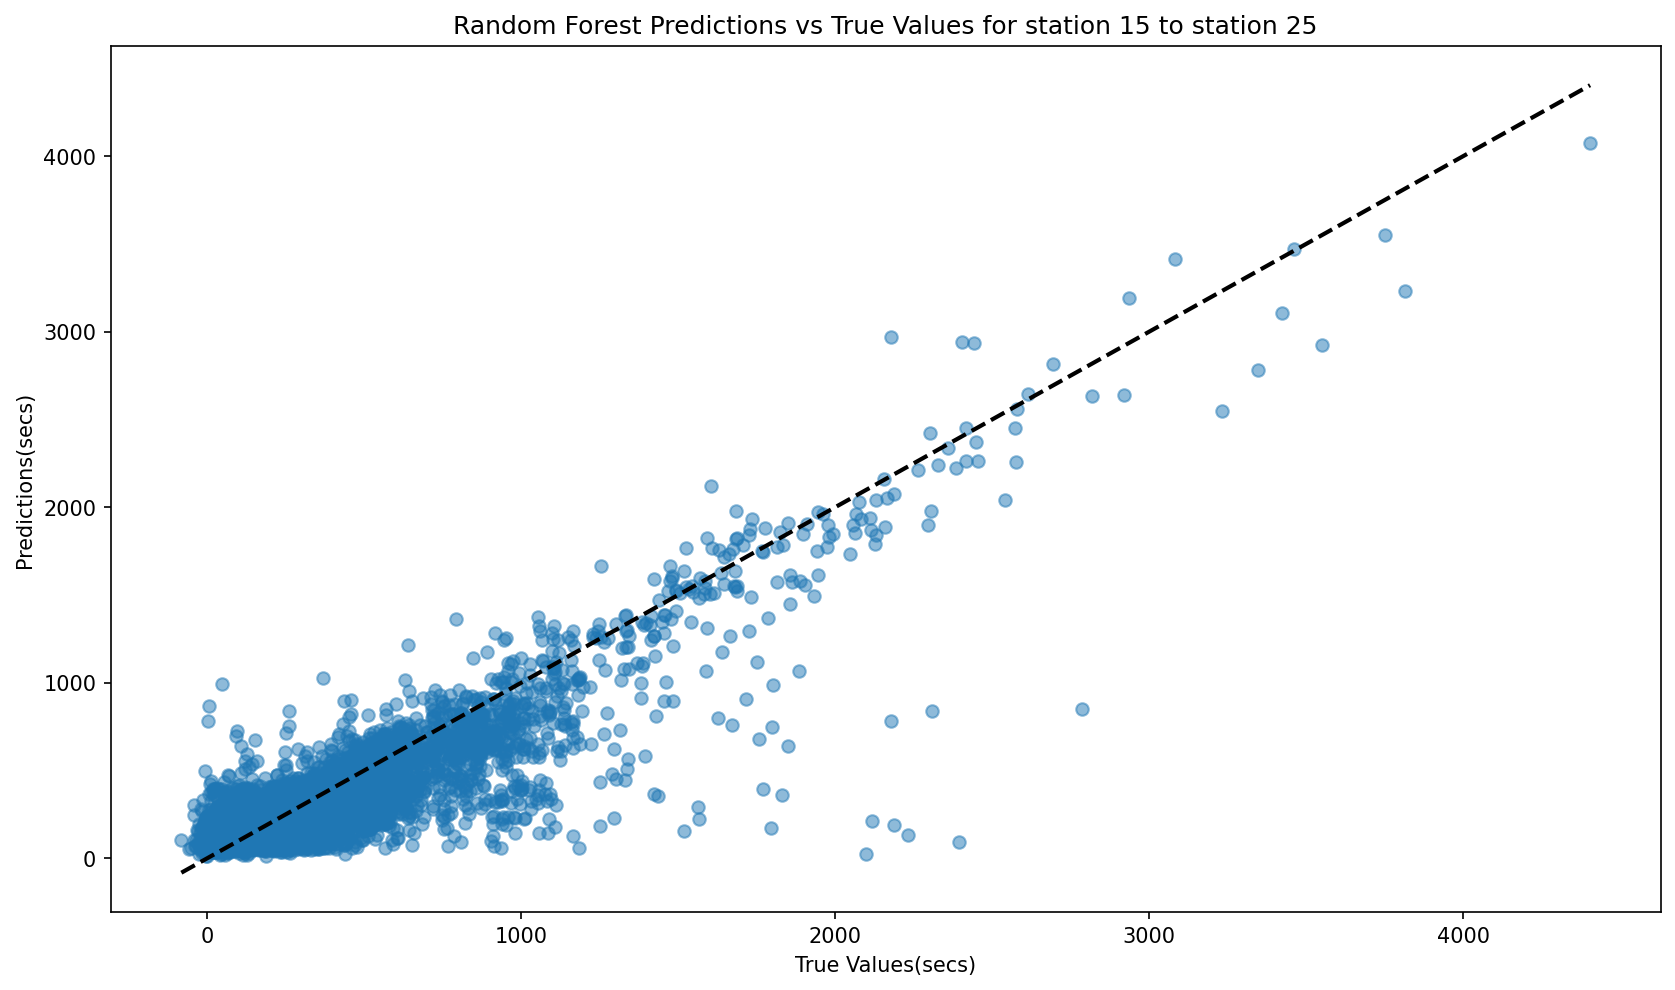

In [10]:
#Q = 10

testX, testY = create_dataset_stop(trajet_valid_df, start_index=15, target_stop=25, stops_per_trip=57)
X_train = testX[:int(len(testX) * 0.8)]
y_train = testY[:int(len(testY) * 0.8)]
X_test = testX[int(len(testX) * 0.8):]
y_test = testY[int(len(testY) * 0.8):]

rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values(secs)')
plt.ylabel('Predictions(secs)')
plt.title('Random Forest Predictions vs True Values for station 15 to station 25')
plt.show()

In [11]:
#Q = 10

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_single_target(dataset, start, target_stop):
    X, y = create_dataset_stop(dataset, start_index=start, target_stop=target_stop)
    pipe = Pipeline([
        ('scaler', StandardScaler()),  
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4))
    ])
    scores = cross_val_score(pipe, X, y, cv=10, scoring='r2', n_jobs=4)
    return scores.mean()

results = {}
for start in range(0, 46):
    target = start + 10
    r2_mean = evaluate_single_target(trajet_valid_df, start, target)
    results[f"start={start}→stop={target}"] = r2_mean

best = max(results, key=results.get)
worst = min(results, key=results.get)
print(f"Best Model: {best} with R²={results[best]:.3f}")
print(f"Worst Model   : {worst} with R²={results[worst]:.3f}")

Best Model: start=27→stop=37 with R²=0.866
Worst Model   : start=44→stop=54 with R²=0.364


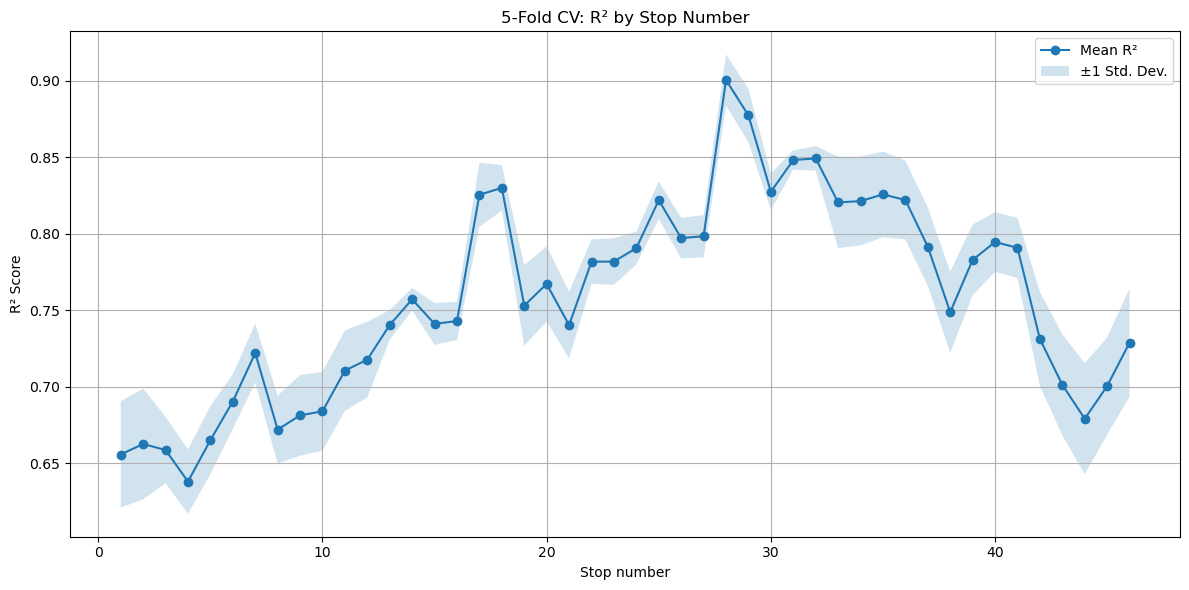

In [32]:
n_splits = 5
all_r2 = []
all_variances = []

for stop in range(46):
    target = [stop + 10]
    r2_scores, variances = testing_target2_with_uncertainty_kfold(target, trajet_valid_df, stop, n_splits=n_splits)
    all_r2.append(r2_scores[0])        
    all_variances.append(variances[0])  

all_r2 = np.array(all_r2)           
all_variances = np.array(all_variances)

mean_r2 = np.mean(all_r2, axis=1)
std_r2 = np.std(all_r2, axis=1)
stops = np.arange(1, 47)

plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops, mean_r2 - std_r2, mean_r2 + std_r2, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² by Stop Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Q = 20

In [21]:
#Naive run  Q = 20
total = []
for i in range(0, 36):
    target = [i+20]
    r2_scores = naive_target(target, trajet_valid_df, i)
    total.append(r2_scores)
print(np.mean(total), np.min(total), np.max(total), np.median(total))

-18258.384559778628 -644158.28888245 0.7626633301903443 0.5850019158500066


In [14]:
# Q = 20

total = []
for i in range(0, 36):
    target = [i+20]
    r2_scores = testing_target2(target, trajet_valid_df, i)
    total.append(r2_scores)
print(np.mean(total), np.min(total),np.max(total))

0.5853727488256869 0.4138055615758647 0.7607644557748309


In [15]:
# Q = 20

total2 = []
for i in range(0, 36):
    target = [i+20]
    r2_scores = testing_target3(target, trajet_valid_df, i)
    total2.append(r2_scores)
print(np.mean(total2), np.min(total2),np.max(total2))

0.5277163104195494 0.26026168104006964 0.7323833882961928


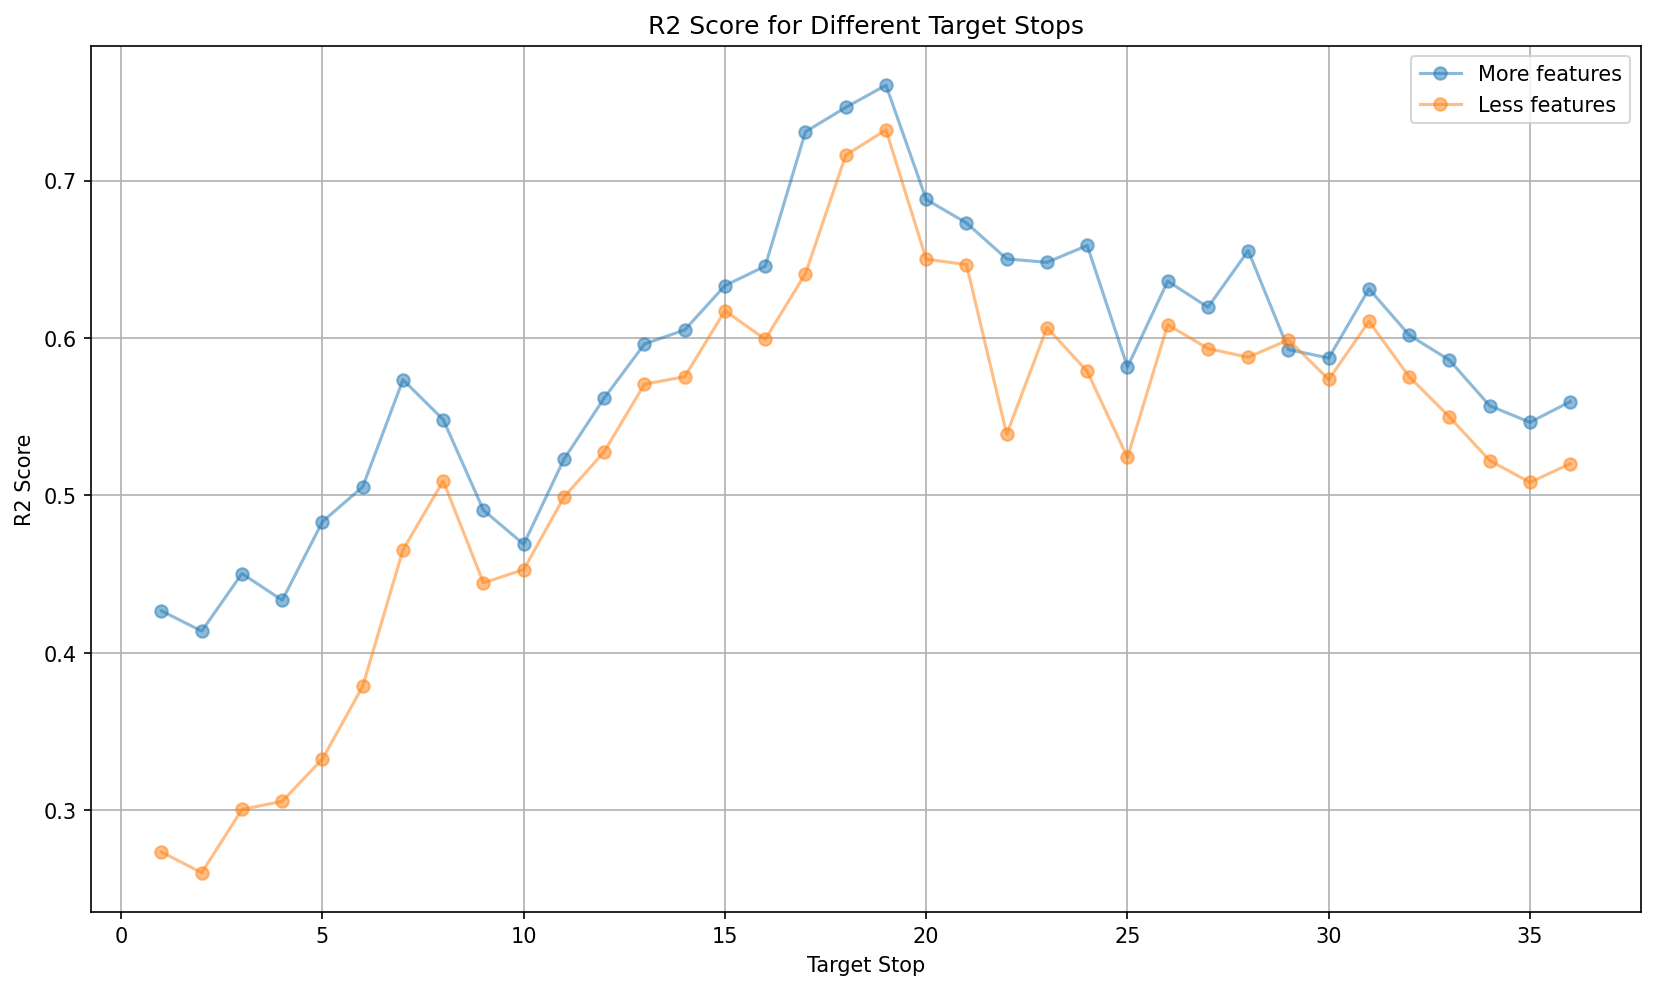

In [17]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.plot(range(1, 37), total, label='More features', marker='o',alpha=0.5)
ax.plot(range(1, 37), total2, label='Less features', marker='o',alpha=0.5)
ax.set_xlabel('Target Stop')
ax.set_ylabel('R2 Score')
ax.set_title('R2 Score for Different Target Stops')
ax.legend()
plt.grid()
plt.show()

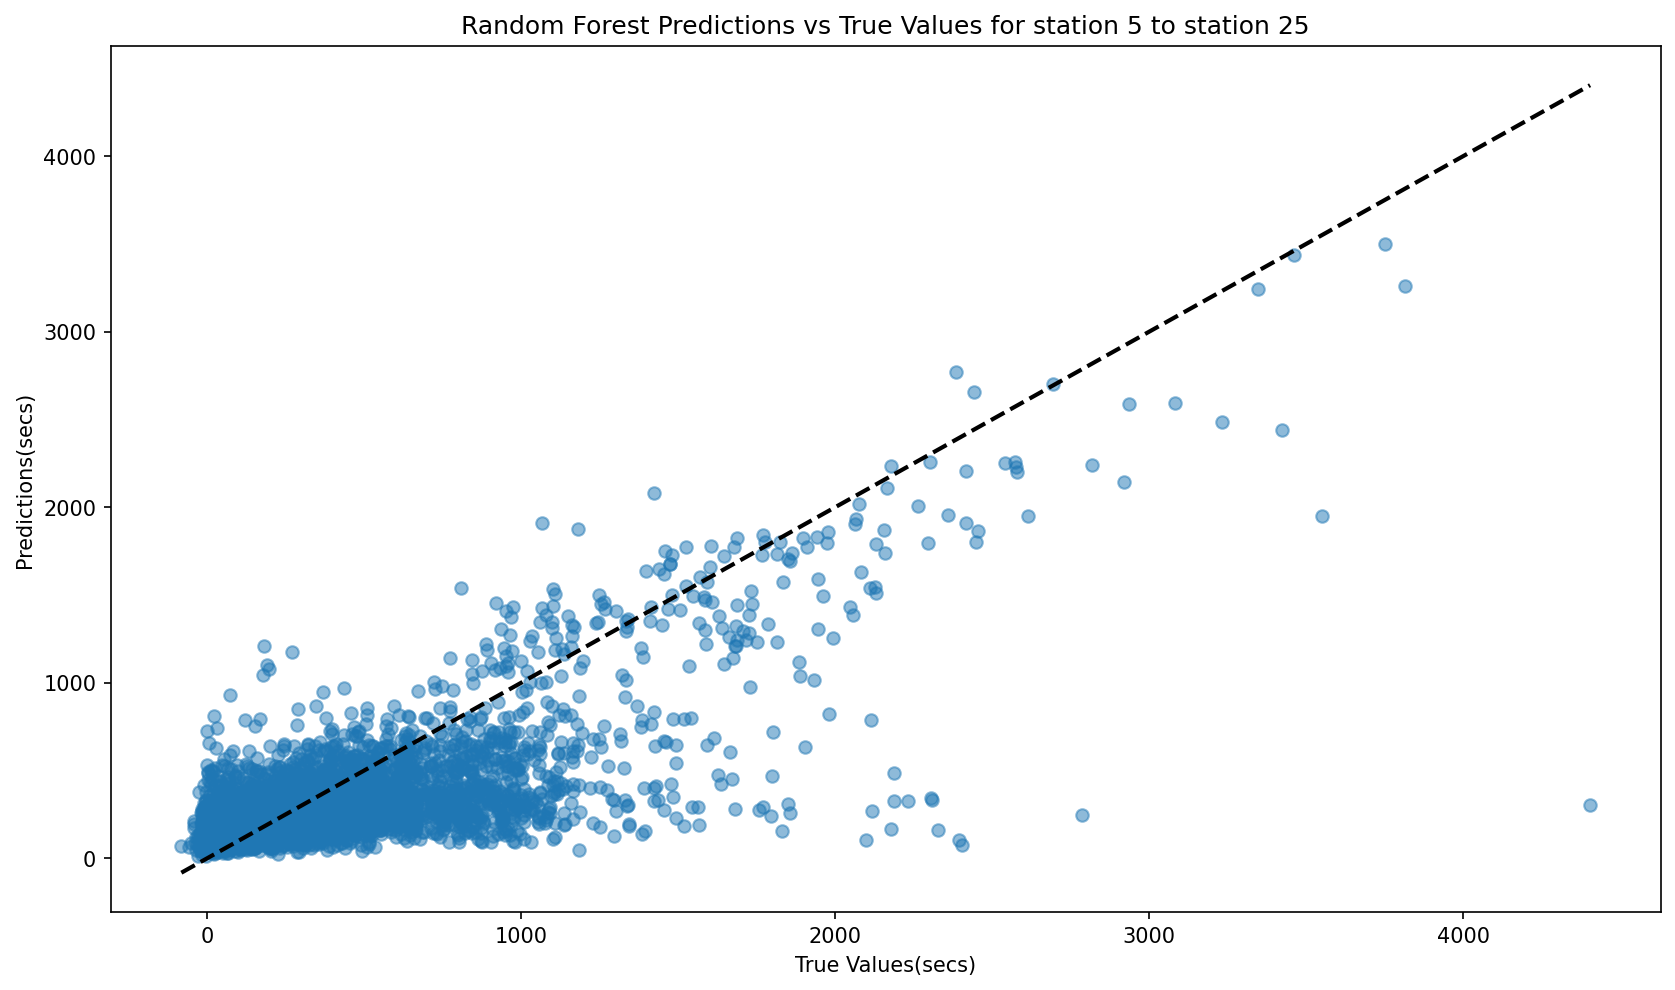

In [18]:
# Q = 20
testX, testY = create_dataset_stop(trajet_valid_df, start_index=5, target_stop=25, stops_per_trip=57)
X_train = testX[:int(len(testX) * 0.8)]
y_train = testY[:int(len(testY) * 0.8)]
X_test = testX[int(len(testX) * 0.8):]
y_test = testY[int(len(testY) * 0.8):]

rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=4)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)

ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values(secs)')
plt.ylabel('Predictions(secs)')
plt.title('Random Forest Predictions vs True Values for station 5 to station 25')
plt.show()

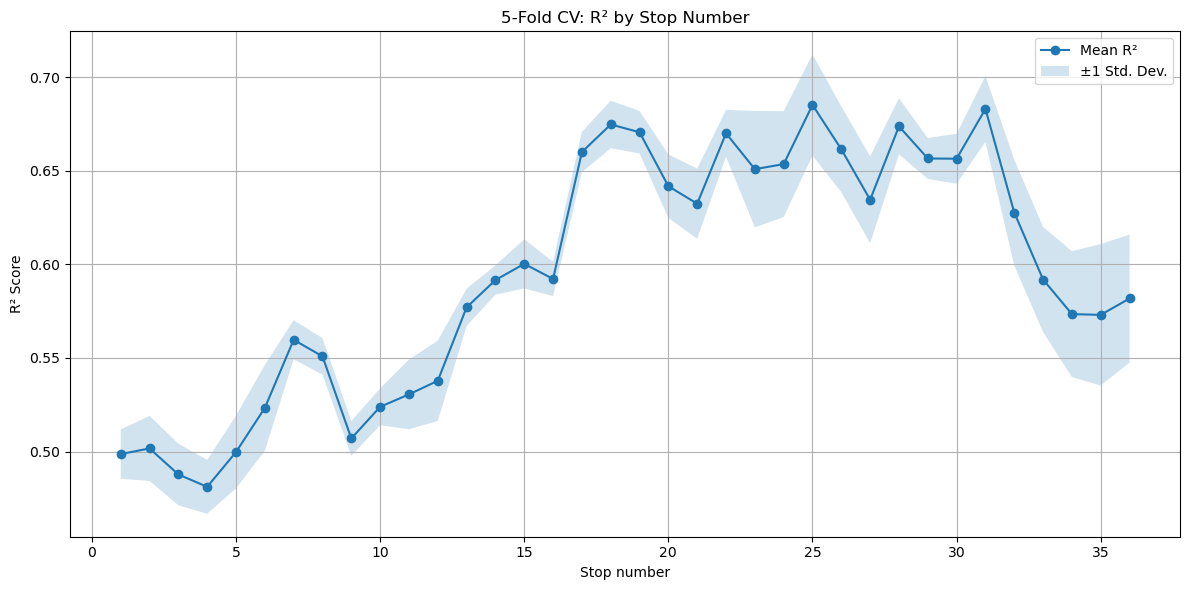

In [34]:
n_splits = 5
all_r2 = []
all_variances = []

for stop in range(36):
    target = [stop + 20]
    r2_scores, variances = testing_target2_with_uncertainty_kfold(target, trajet_valid_df, stop, n_splits=n_splits)
    all_r2.append(r2_scores[0])        
    all_variances.append(variances[0])  

all_r2 = np.array(all_r2)           
all_variances = np.array(all_variances)

mean_r2 = np.mean(all_r2, axis=1)
std_r2 = np.std(all_r2, axis=1)
stops = np.arange(1, 37)

plt.figure(figsize=(12, 6))
plt.plot(stops, mean_r2, marker='o', label='Mean R²')
plt.fill_between(stops, mean_r2 - std_r2, mean_r2 + std_r2, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Stop number')
plt.ylabel('R² Score')
plt.title(f'{n_splits}-Fold CV: R² by Stop Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()